<a href="https://colab.research.google.com/github/puckgroen/TM10007_PROJECT/blob/master/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment template
The aim of this study is to predict the T-stage (high/low) in patients with H&N cancer based on features, extracted from CT. A good performance on this dataset would be above 70% mean accuracy.

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [51]:
# Import packages

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn

from hn.load_data import load_data

from sklearn import model_selection, metrics, feature_selection, preprocessing, neighbors, decomposition, svm
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

from sklearn.ensemble import ExtraTreesClassifier


In [54]:
# Preprocessing function

def data_preprocessing(X_train, y_train, X_validation, y_validation):
    '''Data preprocessing'''

    # 1. Scaling 
    scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    df_X_train_scaled = pd.DataFrame(X_train_scaled)
    X_validation_scaled = scaler.transform(X_validation)
    df_X_validation_scaled = pd.DataFrame(X_validation_scaled)

    bestfeatures = SelectKBest(score_func=mutual_info_classif, k=15)
    fit = bestfeatures.fit(df_X_train_scaled,y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_X_train_scaled.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    best_features = featureScores.nlargest(15,'Score')['Specs']
    #print(best_features)
    df_X_train_features = df_X_train_scaled[best_features]
    df_X_validation_features = df_X_validation_scaled[best_features]
    print(df_X_train_features)

    columns = []
    columns.append(df_X_train_features.columns)
    print(columns)

    # 2.1.1 Build a forest and compute the feature importances
    forest = ExtraTreesClassifier(n_estimators=300,
                                  random_state=0)

    forest.fit(df_X_train_features, y_train)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # 2.1.3 Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(df_X_train_features.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(df_X_train_features.shape[1]), df_X_train_features.columns)
    plt.xlim([-1, df_X_train_features.shape[1]])
    plt.show()

    # 2. Feature selection/extraction
    # Using the Cumulative Summation of the Explained Variance, we concluded that to  
    # retain 95% of the variance we need to use 30 components.
    pca = decomposition.PCA(n_components=30)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_validation_pca = pca.transform(X_validation_scaled)    

    return X_train_pca, X_validation_pca

The number of samples: 113
The number of features: 159
         68        45        104       127       53        90        84   \
0   3.422958  0.442624  1.884923 -0.157650 -0.165762 -1.119984  1.113176   
1  -3.458160  3.306209 -0.083110 -1.151656 -0.167746 -0.802704  1.510294   
2   2.826213  0.950574  1.387922 -0.291685 -0.168364  1.542438 -0.149247   
3  -0.196052  0.252275  0.116869 -0.291316 -0.025941 -1.641423  0.033436   
4   0.622159  0.309046  0.440222 -0.112481 -0.047666  0.230752  0.008716   
..       ...       ...       ...       ...       ...       ...       ...   
62  0.701376 -0.876618  0.553439 -0.185525  0.016298  0.000000  0.047115   
63 -0.205546  0.585692 -0.695660  0.110668  0.023248  0.747831 -0.340830   
64  1.882320 -0.366318  1.041277  0.457658  0.000000 -1.300783  0.354607   
65  0.098739  0.017048  0.209378  0.461365  1.043540 -0.472406 -0.186024   
66 -0.783314  2.393404 -0.497725 -0.581274 -0.168632  0.455460  2.145086   

         0         65        52 

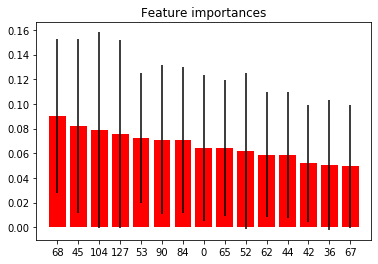

7         43        40        44        32        41        104  \
0  -0.437984  0.727477 -0.919410 -0.524131 -0.459953 -0.628026  1.728531   
1  -0.457995  2.511942 -1.648290 -0.584318 -0.515785 -0.585599  0.185392   
2  -0.468190  1.319102 -1.178374 -0.624150 -0.531865 -0.782495  1.248217   
3   0.045686  0.169398 -0.021255 -0.065989 -0.062699  0.032216  0.196997   
4   0.209930 -0.086632  0.235324  0.276625  0.062221  0.138047  0.019843   
..       ...       ...       ...       ...       ...       ...       ...   
62 -0.078913  0.041317 -0.086198  0.101303  0.167521  0.475206 -0.765403   
63  0.107231 -0.000534 -0.037706  0.082742  0.000000 -0.055931  0.913212   
64 -0.463659  2.482765 -1.984287 -0.656537 -0.538697 -0.598527 -0.574114   
65 -0.424014  0.746514 -0.682700 -0.438687 -0.352145 -0.375054  0.107325   
66 -0.457240  0.969093 -1.146344 -0.603274 -0.507020 -0.710763  2.746892   

         25        52        53        62        42        31        26   \
0  -0.697366 -0.1369

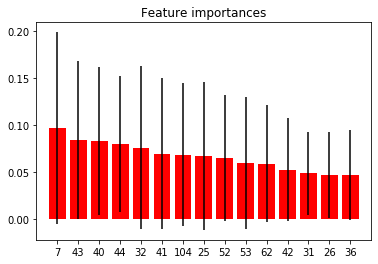

104       43   146       31        40        108       42        62   \
0  -0.125565  2.170466  0.0 -0.467024 -1.440582  1.084886  2.105645  1.344726   
1   0.260269  2.495174  0.0 -0.480518 -1.694229  1.695167  2.616206  2.621235   
2   1.403133  1.310423  0.0 -0.476200 -1.221347 -0.230930  1.302150  2.235812   
3   0.272748  0.168515  0.0 -0.100845 -0.056925  0.096229  0.188323  0.589455   
4   1.744272  1.201994  0.0 -0.421280 -0.864605  0.332635  1.012048  1.166982   
..       ...       ...  ...       ...       ...       ...       ...       ...   
63  1.042900 -0.000265  0.0 -0.015518 -0.073480  0.317744 -0.008721  0.150761   
64  0.178389 -0.456863  0.0  1.902500  0.643629 -0.186290 -0.261928  0.005051   
65 -0.556433  2.466194  0.0 -0.492258 -2.032347  1.034230  3.793222  3.686368   
66  0.176324  0.741717  0.0 -0.381338 -0.722545  0.303365  0.740731  0.799934   
67  3.014668  0.962786  0.0 -0.462536 -1.189115 -0.195131  1.284983  1.325515   

         53        44        38     

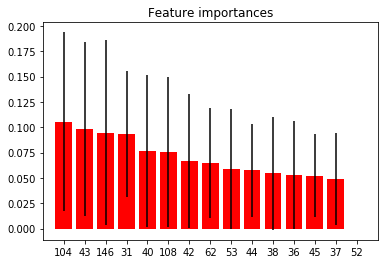

43        53        42        62         52        0         41   \
0   0.669486 -0.186817  0.873555  0.654476  -0.105111 -0.328046 -0.514453   
1   2.087183 -0.190178  2.083198  1.427608  -0.111230 -0.430171 -0.342317   
2   2.405170 -0.191414  2.613774  2.894577  -0.113479 -0.453981 -0.476201   
3   0.126663 -0.070430  0.090712  0.559647  -0.059204 -0.320384  0.080830   
4  -0.122369  0.050145 -0.143579  0.323672  -0.004323 -0.149891  0.176249   
..       ...       ...       ...       ...        ...       ...       ...   
63 -0.506063  6.726112 -0.459287 -0.434952  12.478807  4.836563  1.619353   
64  0.002083  0.133508  0.144962 -0.324398   0.477991  0.929173  0.480236   
65 -0.485773  1.862652 -0.377191 -0.111953   0.820522  0.554641  1.483848   
66  0.688002 -0.159727  0.664775  0.801531  -0.099843 -0.392735 -0.286371   
67  0.904496 -0.190135  1.230363  1.405530  -0.111152 -0.365680 -0.589051   

         40        1         37        7         32        104       45   \
0  -0.88

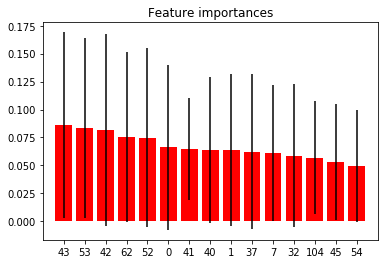

43        0         53        42        104       45        28   \
0   2.199760 -0.387024 -0.206225  2.250799 -0.164002  3.187124 -0.415831   
1   2.528810 -0.410622 -0.207252  2.794865  0.251466  3.039243  0.238198   
2   1.328215 -0.382341 -0.207096  1.394576  1.482109  0.848762 -0.614174   
3   0.171037 -0.278215 -0.106706  0.207656  0.264903  0.635035 -0.293536   
4   1.218336 -0.364603 -0.192688  1.085437  1.849450  1.475149  0.586604   
..       ...       ...       ...       ...       ...       ...       ...   
62 -0.117832  0.111390  0.052995 -0.199086  0.548307 -0.965032  1.035874   
63  0.000000 -0.169590  0.030039 -0.002319  1.094207 -0.458473  0.162118   
64 -0.462704  0.589020  1.499832 -0.272142  0.163297 -0.077919  0.000000   
65  2.499442 -0.413288 -0.207473  4.049121 -0.627964  2.281012 -0.755557   
66  0.975930 -0.323107 -0.206190  1.376283  3.217420  0.267299 -0.506487   

         26        108       62        32        44        40        52   \
0  -0.389406  1.0248

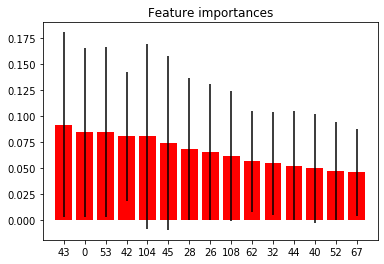

40        104       44        43        53        7         31   \
0  -1.043180  1.936290 -0.636662  0.770139 -0.235695 -0.499222 -0.412820   
1  -1.554656 -0.094232 -0.735537  2.229744 -0.238515 -0.500951 -0.443738   
2  -1.825029  0.288836 -0.699541  2.557132 -0.239552 -0.517545 -0.454511   
3  -1.320963  1.423508 -0.741156  1.362602 -0.239394 -0.526880 -0.451064   
4  -0.079756  0.301225 -0.158024  0.211270 -0.138048 -0.056353 -0.151397   
..       ...       ...       ...       ...       ...       ...       ...   
62  0.026033  0.562528  0.068558 -0.076139  0.023174  0.173207 -0.021869   
63 -0.149418 -0.726232  0.016751  0.083007  0.033055 -0.170441  0.000000   
64 -0.097403  1.065857 -0.002639  0.041097  0.000000  0.000000 -0.083275   
65 -2.185443 -0.522012 -0.774991  2.527913 -0.239775 -0.522731 -0.463884   
66 -0.789269  0.205492 -0.547395  0.789203 -0.212967 -0.486430 -0.375330   

         42        0         67        36        61        52        32   \
0   1.064541 -0.3704

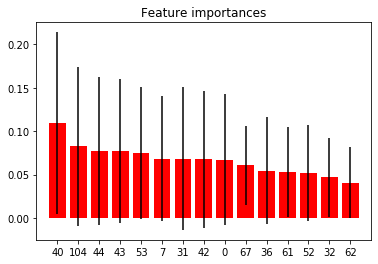

43        31        45        0         90        42        36   \
0   0.676972 -0.373686  0.375573 -0.388604 -1.029282  0.859207 -0.475496   
1   2.367940 -0.424968  2.990295 -0.519454  0.771797  2.491527 -0.618825   
2  -0.094483  0.165389  0.192228 -0.203497 -1.523169 -0.094862  0.190022   
3   1.134150 -0.366795  1.472627 -0.471209 -0.413858  0.927844 -0.434172   
4   0.109526 -0.137672  0.246910 -0.344665  0.250085  0.135540 -0.085861   
..       ...       ...       ...       ...       ...       ...       ...   
63  0.026763  0.134099  0.513377  0.917681  0.739842  0.175788  0.204360   
64 -0.012895  0.031667 -0.403602 -0.266765 -1.200527 -0.067171  0.088676   
65 -0.448524  1.915181 -0.034344  0.528532 -0.415920 -0.313989  1.208998   
66  0.695011 -0.327572  0.908925 -0.455818 -0.373367  0.663372 -0.391409   
67  0.905928 -0.407309  0.300627 -0.427707  1.142501  1.193892 -0.540809   

         52        53        104       44        40        62        37   \
0  -0.107995 -0.1693

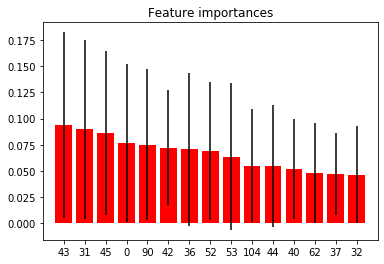

7         53        43        17        104       26        62   \
0  -0.342473 -0.205661  0.720204  0.468552  2.016523 -0.721315  0.651420   
1  -0.343935 -0.208531  2.164966 -0.307118 -0.164507 -0.352378  1.336416   
2  -0.365870 -0.209426  1.306642  0.515810  1.465732 -1.011709  2.243718   
3   0.032171 -0.106288  0.167017  0.274022  0.260263 -0.367653  0.567402   
4   0.159392 -0.003338 -0.086769 -1.114201  0.057115  0.373374  0.358327   
..       ...       ...       ...       ...       ...       ...       ...   
63 -0.064342  0.067839  0.040059  0.539217 -0.843353 -0.364507 -0.215864   
64  1.780507  1.544219 -0.457110  0.387873  0.159636  0.075364 -0.027637   
65 -0.362360 -0.209813  2.460103  0.789992 -0.623996 -0.302373  3.720669   
66 -0.331652 -0.182531  0.739074 -0.115874  0.157434 -0.329788  0.781711   
67 -0.357388 -0.208494  0.959701  0.694801  3.184312 -1.238242  1.316855   

         45        37        130       40        0         44        133  \
0   0.436660 -0.2539

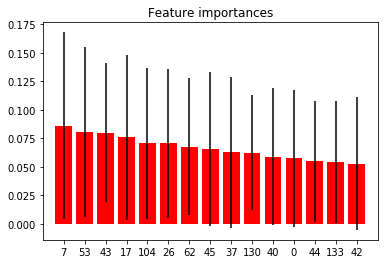

62        43        44        0         31        32        53   \
0   0.847021  0.690804 -0.574373 -0.325370 -0.373642 -0.511285 -0.133628   
1   1.749542  2.091467 -0.663945 -0.412046 -0.403192 -0.513986 -0.135437   
2   3.462018  2.405634 -0.631336 -0.432255 -0.413488 -0.564594 -0.136103   
3   2.944962  1.259342 -0.669035 -0.408036 -0.410193 -0.579948 -0.136002   
4   0.736322  0.154503 -0.140766 -0.318867 -0.123793 -0.131979 -0.070963   
..       ...       ...       ...       ...       ...       ...       ...   
62 -0.292609 -0.121300  0.064499  0.014775  0.000000  0.000000  0.032501   
63 -0.295674  0.031420  0.017566  0.741675  0.020901  0.087839  0.038842   
64  0.147801 -0.008797  0.000000 -0.225845 -0.058687 -0.072113  0.017629   
65 -0.047674 -0.450573  1.265760  0.423797  1.404783  1.225192  0.969850   
66  1.723769  0.922991 -0.649277 -0.357311 -0.399767 -0.556225 -0.135414   

         42        40        28        104       26        83        37   \
0   0.881819 -0.9055

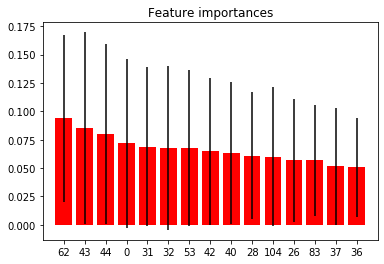

43        53        1          141       45        42        37   \
0   0.750761 -0.159355  0.769947  -0.201617  0.403540  1.004319 -0.333108   
1   2.492788 -0.162948  0.821980   1.423098  3.065090  2.778039 -0.372062   
2   1.328316 -0.162801  1.861543 -10.252608  0.901562  1.386180 -0.367085   
3   0.205954 -0.068375 -0.299239  -1.285315  0.690465  0.206406  0.340145   
4  -0.043988  0.025878  0.234052  -0.611776  0.216913 -0.032395  0.624882   
..       ...       ...       ...        ...       ...       ...       ...   
62  2.483617 -0.163011  0.584441   1.322976  4.130211  2.846199 -0.384338   
63 -0.429084  5.244464  0.089250   0.000000 -0.697028 -0.354180  0.322295   
64  2.464304 -0.163156  0.568121   1.337144  2.316189  4.024743 -0.369988   
65  0.769345 -0.138179  1.169327  -0.313160  0.946444  0.791520 -0.005205   
66  0.986630 -0.161949  1.044205  -3.467652  0.327253  1.367997 -0.350859   

         104       74        0          52        138       26        36   \
0   1.8

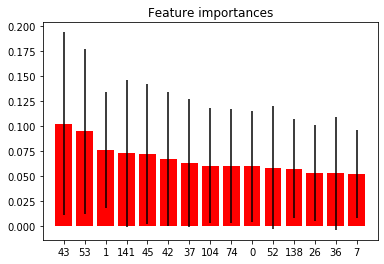

53        43        62        104       7         52        42   \
0  -0.246088  2.090482  1.268386 -0.202031 -0.503425 -0.185314  2.204657   
1  -0.247330  2.403224  2.571743  0.193356 -0.523973 -0.187876  2.741055   
2  -0.247141  1.262132  2.178214  1.364516 -0.535531 -0.187486  1.360502   
3  -0.125679  0.162305  0.497229  0.206144  0.047089 -0.126060  0.190312   
4  -0.004439 -0.082619  0.287572  0.010933  0.233305 -0.063554 -0.046550   
..       ...       ...       ...       ...       ...       ...       ...   
63  0.039768 -0.000255  0.049309  0.995364  0.116866 -0.040778 -0.016704   
64  1.818071 -0.440027 -0.099467  0.109449  2.606164  0.875891 -0.282724   
65 -0.247597  2.375312  3.659279 -0.643567 -0.530394 -0.188427  3.977632   
66 -0.215469  0.714384  0.712135  0.107332 -0.485445 -0.172345  0.770673   
67 -0.246045  0.927307  1.248770  3.015952 -0.523116 -0.185225  1.342467   

         0         41        44        26        54        17        31   \
0  -0.509088 -0.3713

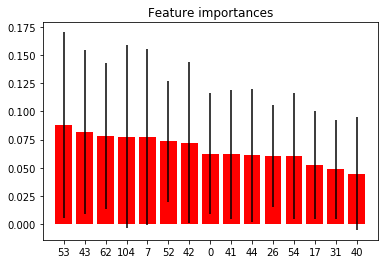

45        43        0         42        104       40        36   \
0   0.360956  0.715631 -0.376048  0.936592  1.827833 -0.887918 -0.503290   
1   2.742040  2.148912 -0.478730  2.093033 -0.117578 -1.343883 -0.692801   
2   0.202680 -0.084928 -0.196922 -0.035807  0.080102  0.216299  0.183789   
3   1.308010  1.190057 -0.455984  1.006548  1.661042 -0.796557 -0.460627   
4   0.249885  0.126777 -0.333529  0.199022  0.399738 -0.178035 -0.101031   
..       ...       ...       ...       ...       ...       ...       ...   
63  0.479918  0.040892  0.888030  0.240043 -0.723087 -0.091158  0.198592   
64 -0.311682 -0.000262 -0.258145 -0.007583  0.993885 -0.044787  0.079160   
65  0.007088 -0.452326  0.511455 -0.259144  0.171548  0.636648  1.235777   
66  1.983038  2.441703 -0.505375  3.769635 -0.527428 -1.906210 -0.643385   
67  0.821383  0.734351 -0.441090  0.736994  0.169583 -0.661565 -0.416478   

         62        24        7         38        52        44        68   \
0   0.756362 -1.5507

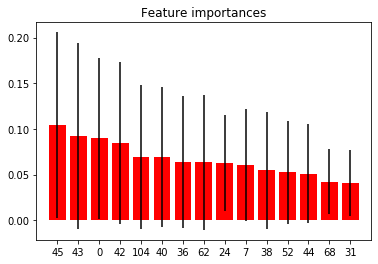

In [55]:
# Data loading and preprocessing

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = sklearn.preprocessing.label_binarize(y_labels, ['T12', 'T34']) # 0 now stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y,
                                                    stratify=y, 
                                                    test_size=0.2)

# Loop over the folds
for _ in range(0,3):
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        train_scores = []
        test_scores = []
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]

        # Preprocessing 
        X_train_pca, X_validation_pca = data_preprocessing(X_train, y_train, X_validation, y_validation)